In [1]:
import numpy as np
import scipy as scip
from scipy import linalg
from scipy import optimize
from scipy import interpolate
import pandas as pd
import sympy as sym
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

The **relevant levels of human capital** are:

In [2]:
h_vec = np.linspace(0.1,1.5,100) 

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

We start by defining the consumption function, which will depend on whether or not she is working. If she is not working, then $l=0$ and she will consume $c=b$, if she is working she will consume $c=w*h$. 

Afterwards we define the utility function and bequest, the utility function is the first part of $v_2(h_2)$ defined in the text, and bequest is the second part in $v_2(h_2)$.

In [3]:
l = [0, 1]

def consumption(w,h,b,l):
    if l == 0:
        c = b
    elif l == 1:
        c = w*h
    return c

def utility(rho,h,w,b,l):
    return consumption(w,h,b,l)**(1-rho)/(1-rho)

def bequest(l,gamma):
    return gamma*l

def v2(l2,h2,w,b,rho,gamma):
    return utility(rho,h2,w,b,l2) - bequest(l2,gamma)

In [4]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

We are now ready to solve the model. We do that by maximizing the utility given a level of human capital.

In [5]:

def solve_period_2(w,b,rho,gamma):

    # h2_vec is the same as h_vec
    # we then define an array without any entries, we define 100 of those for both l2 and v2.
    h2_vec = np.linspace(0.1,1.5,100)
    l2_vec = np.empty(100)
    v2_vec = np.empty(100)
    
    # Solve for each h2 in grid
    for i,h2 in enumerate(h2_vec):
        
        # We calculate the utility when working, that is v2_Yes and when not working (v2_No).
        v2_No = v2(l[0],h2,w,b,rho,gamma)
        v2_Yes = v2(l[1],h2,w,b,rho,gamma)
        
        # We then find the utility maximizing level of labor.
        v2_vec[i] = max(v2_No,v2_Yes) #the vector is the maximum of the utility of either working or not working
        l2_vec[i] = v2_Yes>v2_No
        
    return h2_vec,v2_vec,l2_vec

In [6]:
h2_vec,v2_vec,l2_vec = solve_period_2(w,b,rho,gamma);

In [7]:
solution = np.where(l2_vec == 1)[0][0];
print(str(round(h2_vec[solution],3)))

0.567


We have that solution $h_2^*=0.567$ and she chooses the work whenever $h_2$ is greater than or equal to $0.567$


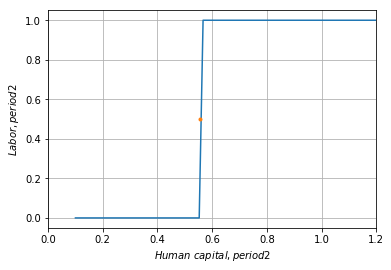

In [8]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,3)
ax.plot(h2_vec,l2_vec)
ax.grid()
ax.set_xlabel('$Human\ capital, period 2$')
ax.set_ylabel('$Labor, period 2$')
ax.set_xlim([0.0,1.2])
ax.plot(0.555567,0.5,marker='.')

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 


To solve this, we start out by constructing an interpolator, since the values in period 1 will depend on the values from period 2.


In [9]:
v2_interp = interpolate.RegularGridInterpolator([h2_vec], v2_vec,bounds_error=False,fill_value=None)
    

We can now define the utility in period 1, which will depend on the value of v2 in period 2. 

In [10]:
def v1(l1,h1,w,b,rho,gamma,beta,Delta,v2_interp):
    
    # The level of v2 when gain is 0 with probability 50%
    h2_zero = h1 + l1
    v2_zero = v2_interp([h2_zero])[0]
    
    # The level of v2 when gain is Delta with probability 50%
    h2_delta = h1 + l1 + Delta
    v2_delta = v2_interp([h2_delta])[0]
    
    # We know calculate the expected value of v2
    v2_expected = 0.5 * v2_zero + 0.5 * v2_delta
    
    # And at last we get the total utility
    return utility(rho,h1,w,b,l1) - bequest(l1,gamma) + beta*v2_expected

From here we do it the same way as we did in question 1.

In [11]:
def solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp):
    # This is done in the same way as in question 1:
    h1_vec = np.linspace(0.1,1.5,100)
    l1_vec = np.empty(100)
    v1_vec = np.empty(100)
    
    
    for i,h1 in enumerate(h1_vec):
        
        
        v1_No = v1(l[0],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        v1_Yes = v1(l[1],h1,w,b,rho,gamma,beta,Delta,v2_interp)
        
        
        v1_vec[i] = max(v1_No,v1_Yes)
        l1_vec[i] = v1_Yes > v1_No
        
    return h1_vec,v1_vec,l1_vec

In [12]:
h1_vec,v1_vec,l1_vec = solve_period_1(w,b,rho,gamma,Delta,beta,v2_interp)

In [13]:
solution = np.where(l1_vec == 1)[0][0];
print(str(round(h1_vec[solution],3)))

0.355


We have that $h_1^*=0.355$

So she will decide to work in period 1 if her human capital is greater that or equal to $0.355$. We illustrate a figure below with the labor supply as a function of human capital.

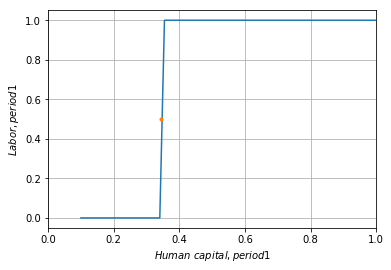

In [14]:
fig = plt.figure(figsize=(20,4))
ax = fig.add_subplot(1,3,3)
ax.plot(h1_vec,l1_vec)
ax.grid()
ax.set_xlabel('$Human\ capital, period 1$')
ax.set_ylabel('$Labor, period 1$')
ax.set_xlim([0.0,1.0])
ax.plot(0.3445,0.5,marker='.')

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

The worker might work even though her potential wage income in period 1 is lower than the unemployment benefit. The reason is the stochastic experience gain we have defined. She accumulates human capital, if she doesn't work than $h_2=h_1+l_1$ while if she works then $h_2=h_1+l_1+\Delta$. The reason she might be working in period 1 even though her wage income is lower than the unemployment benefit, is because she might accumulate enough human capital such that in period 2 she will get an even higher wage, and thus be able to consume more.

In [15]:
def v1NO(l1,h1,w,b,rho,gamma,beta,v2_interp):
    
    # The level of v2 when gain is 0 with probability 50%
    h2_zero = h1 + l1
    v2_zero = v2_interp([h2_zero])[0]
    
    # d. total value
    return utility(rho,h1,w,b,l1) - bequest(l1,gamma) + beta*v2_zero

In [16]:
def solve_period_1NO(w,b,rho,gamma,Delta,beta,v2_interp):
    # a. grids
    h1NO_vec = np.linspace(0.1,1.5,100)
    l1NO_vec = np.empty(100)
    v1NO_vec = np.empty(100)
    
    # b. solve for each h1 in grid
    for i,h1 in enumerate(h1_vec):
        
        # We now calculate the utility when working (v1_1) and not working (v1_0)
        v1NO_0 = v1NO(l[0],h1,w,b,rho,gamma,beta,v2_interp)
        v1NO_1 = v1NO(l[1],h1,w,b,rho,gamma,beta,v2_interp)
        
        
        v1NO_vec[i] = max(v1NO_0,v1NO_1)
        l1NO_vec[i] = v1NO_1 > v1NO_0
        
    return h1NO_vec,v1NO_vec,l1NO_vec

The idea here was to show the utility as defined in question two and a utility function where there are no stochastic gain (so only $h_1+l_1$ with probability 1), but it somehow messes up. The idea was to show how the utilities differ, and that might explain why sometimes she might choose to work even though she would consume less in the first period.

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [17]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [18]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [19]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [17]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$


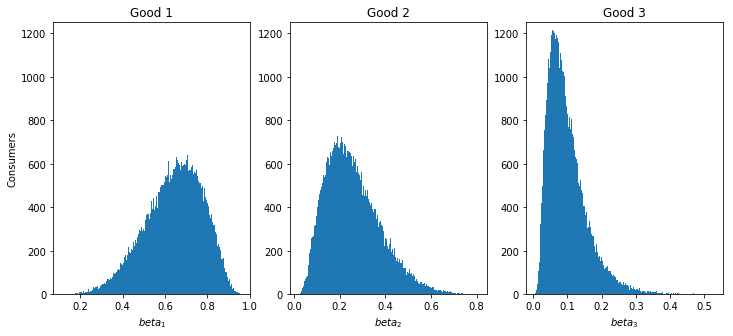

In [18]:
# Plotting histogram of budget shares

# Plotting histogram of each beta with 200 bins.
fig = plt.figure(figsize=(12,5))
ax = fig.add_subplot(1,3,1)
ax.hist(betas[:,0],bins=200,histtype='bar')
ax.set_xlabel('$beta_1$')
ax.set_ylabel('Consumers')
ax.set_title('Good 1')
ax.set_ylim([0, 1250])

ax = fig.add_subplot(1,3,2)
ax.hist(betas[:,1],bins=200,histtype='bar')
ax.set_xlabel('$beta_2$')
ax.set_title('Good 2')
ax.set_ylim([0, 1250])

ax = fig.add_subplot(1,3,3)
ax.hist(betas[:,2],bins=200,histtype='bar')
ax.set_xlabel('$beta_3$')
ax.set_title('Good 3')
ax.set_ylim([0, 1250]);

**Question 2:** Plot the excess demand functions.

In [19]:
#We first define the demand functions, as we set p3=1 we have just excluded that term.

def demand_good1(p1,p2,e1,e2,e3,betas):
    I = e1*p1+e2*p2+e3
    return betas[:,0]*I/p1

def demand_good2(p1,p2,e1,e2,e3,betas):
    I = e1*p1+e2*p2+e3
    return betas[:,1]*I/p2

def demand_good3(p1,p2,e1,e2,e3,betas):
    I = e1*p1+e2*p2+e3
    return betas[:,2]*I

#We then define the excess demand functions, and supply functions for good 1 and good 2.

def excess1(p1,p2,e1,e2,e3,betas):
    demand = np.sum(demand_good1(p1,p2,e1,e2,e3,betas))
    supply = np.sum(e1)
    excess1 = demand - supply
    return excess1

def excess2(p1,p2,e1,e2,e3,betas):
    demand = np.sum(demand_good2(p1,p2,e1,e2,e3,betas))
    supply = np.sum(e2)
    excess2 = demand - supply
    return excess2

# We then define an array of prices
p1_s = np.linspace(0.1,10,100)
p2_s = np.linspace(0.1,10,100)

# Creating grids for excess demand
excess_grid1 = np.empty((100,100))
excess_grid2 = np.empty((100,100))

# And then we transform our price-vectors into grids using meshgrid
p1_grid, p2_grid = np.meshgrid(p1_s,p2_s,indexing='ij')

# We can then calculate excess demand for each combination of prices:
for i,p1 in enumerate(p1_s):
    for j,p2 in enumerate(p2_s):
        excess_grid1[i,j] = excess1(p1,p2,e1,e2,e3,betas)
        excess_grid2[i,j] = excess2(p1,p2,e1,e2,e3,betas)

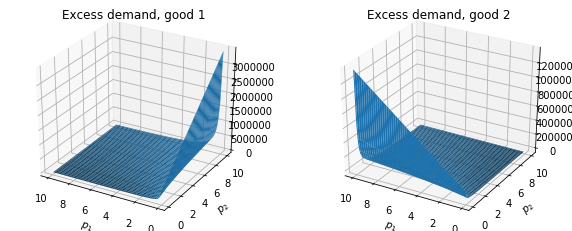

In [20]:
# We can now plot our results
fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.plot_surface(p1_grid, p2_grid, excess_grid1)
ax.invert_xaxis()
ax.set_title('Excess demand, good 1')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$')

ax = fig.add_subplot(1,2,2, projection='3d')
ax.plot_surface(p1_grid, p2_grid, excess_grid2)
ax.invert_xaxis()
ax.set_title('Excess demand, good 2')
ax.set_xlabel('$p_1$')
ax.set_ylabel('$p_2$');

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

In [21]:
def tatonnement(p1,p2,e1,e2,e3,betas,tol=1e-7,kappa=0.2,prints=True):
  # Calculating initial excess demands
    z_1 = excess1(p1,p2,e1,e2,e3,betas)
    z_2 = excess2(p1,p2,e1,e2,e3,betas)
    
# Setting iteration counter to 1
    t = 1
    
    # We start the loop here, we will have a maximum of 20.000 loops
    while t < 20000:
        
        # We calculate the initial excess demands
        z_1 = excess1(p1,p2,e1,e2,e3,betas)
        z_2 = excess2(p1,p2,e1,e2,e3,betas)

        # Set our tolerance level:
        if abs(z_1)<tol and abs(z_2)<tol:
            if prints:
                print(f'\nIn the Walras equilibrium we have: p1 = {p1:.2f} and p2 = {p2:.2f}')
            p1_eq = p1
            p2_eq = p2
            return p1_eq, p2_eq

        # If no convergence, we will multiply our excess demand by kappa and take the average:
        else:
            p1 += kappa*z_1/N
            p2 += kappa*z_2/N

        # We then print the iteration proces   
        if prints:
            if t <= 10 or t%1000==0:
                print(f'Iter {t:6.0f}: Excess good 1 = {z_1:10.2f}, Excess good 2 = {z_2:10.2f} => p1 = {p1:10.2f}, p2 = {p2:10.2f}')

        t += 1
        
    # Print statement if maximum numbers of iterations is exceeded
    if t == 20000: 
        text = 'No convergence \n'
        print(text)
        return None, None

In [22]:
# Finding Walras-equilibrium prices

# Initial guess on prices
p1 = 4
p2 = 1

# Calling function to find equilibrium prices
p1_eq, p2_eq = tatonnement(p1,p2,e1,e2,e3,betas)

Iter      1: Excess good 1 =   -1802.03, Excess good 2 =   27583.49 => p1 =       3.99, p2 =       1.11
Iter      2: Excess good 1 =    -890.71, Excess good 2 =   21094.24 => p1 =       3.99, p2 =       1.19
Iter      3: Excess good 1 =    -200.19, Excess good 2 =   16961.42 => p1 =       3.99, p2 =       1.26
Iter      4: Excess good 1 =     346.52, Excess good 2 =   14060.01 => p1 =       3.99, p2 =       1.32
Iter      5: Excess good 1 =     790.31, Excess good 2 =   11901.20 => p1 =       3.99, p2 =       1.37
Iter      6: Excess good 1 =    1156.25, Excess good 2 =   10231.46 => p1 =       4.00, p2 =       1.41
Iter      7: Excess good 1 =    1461.18, Excess good 2 =    8903.73 => p1 =       4.00, p2 =       1.44
Iter      8: Excess good 1 =    1717.07, Excess good 2 =    7825.81 => p1 =       4.01, p2 =       1.47
Iter      9: Excess good 1 =    1932.83, Excess good 2 =    6936.50 => p1 =       4.02, p2 =       1.50
Iter     10: Excess good 1 =    2115.29, Excess good 2 =    6193

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

In [23]:
def u(p1, p2, e1, e2, e3, betas, gamma):

    # Income is given by:
    I = p1*e1+p2*e2+e3
    
    # Demand is given by:
    demand1 = betas[:,0]*(I/p1)
    demand2 = betas[:,1]*(I/p2)
    demand3 = betas[:,2]*I
    
    # Calculating utility
    u = (demand1**betas[:,0]+demand2**betas[:,1]+demand3**betas[:,2])**gamma
    return u

In [24]:
# We make a function that creates a vector of utilities
u_vec = u(p1_eq, p2_eq, e1, e2, e3, betas, gamma)

# we can then find the mean and variance
mean = np.mean(u_vec)
var = np.var(u_vec)
print(f'Mean: {mean:.2f}')
print(f'Variance: {var:.2f}')

Mean: 2.38
Variance: 0.21


Text(0, 0.5, 'Consumers')

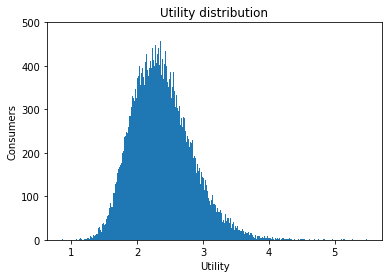

In [25]:
# Plotting distribution of utilities, and printing mean and variance
plt.hist(u_vec, bins=500)
plt.title('Utility distribution')
plt.xlabel('Utility')
plt.ylabel('Consumers')

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

In [26]:
e1_new = np.ones(N)*np.mean(e1)
e2_new = np.ones(N)*np.mean(e2)
e3_new = np.ones(N)*np.mean(e3)


In [27]:
p1 = 4
p2 = 1

p1_new, p2_new = tatonnement(p1,p2,e1_new,e2_new,e3_new,betas)

Iter      1: Excess good 1 =   -1811.29, Excess good 2 =   27618.68 => p1 =       3.99, p2 =       1.11
Iter      2: Excess good 1 =    -898.66, Excess good 2 =   21117.58 => p1 =       3.99, p2 =       1.19
Iter      3: Excess good 1 =    -207.23, Excess good 2 =   16978.68 => p1 =       3.99, p2 =       1.26
Iter      4: Excess good 1 =     340.19, Excess good 2 =   14073.55 => p1 =       3.99, p2 =       1.32
Iter      5: Excess good 1 =     784.53, Excess good 2 =   11912.24 => p1 =       3.99, p2 =       1.37
Iter      6: Excess good 1 =    1150.94, Excess good 2 =   10240.69 => p1 =       4.00, p2 =       1.41
Iter      7: Excess good 1 =    1456.26, Excess good 2 =    8911.60 => p1 =       4.00, p2 =       1.44
Iter      8: Excess good 1 =    1712.48, Excess good 2 =    7832.63 => p1 =       4.01, p2 =       1.47
Iter      9: Excess good 1 =    1928.53, Excess good 2 =    6942.48 => p1 =       4.02, p2 =       1.50
Iter     10: Excess good 1 =    2111.24, Excess good 2 =    6198

We see that the changes in the distribution of endowments doesn't have a significant effect on the prices. In fact the prices are identical to the previous situation.

In [28]:
def u_new(p1, p2, e1, e2, e3, betas, gamma):

    # Income is given by:
    I = p1*e1+p2*e2+e3
    
    # Demand is given by:
    demand1_new = betas[:,0]*(I/p1)
    demand2_new = betas[:,1]*(I/p2)
    demand3_new = betas[:,2]*I
    
    # Calculating utility
    u = (demand1_new**betas[:,0]+demand2_new**betas[:,1]+demand3_new**betas[:,2])**gamma
    return u_new

In [29]:
# We make a function that creates a vector of utilities
u_vec_new = u(p1_eq, p2_eq, e1, e2, e3, betas, 1.5)

# we can then find the mean and variance
mean = np.mean(u_vec_new)
var = np.var(u_vec_new)
print(f'Mean: {mean:.2f}')
print(f'Variance: {var:.2f}')

Mean: 5.22
Variance: 3.71


Even though the prices are unchanged, gamma will have an impact on the mean and variance. By increasing gamma from $0.8$ to $1.5$ the mean have increased from $2.38$ to $5.22$ while the variance have increased from $0.21$ to $3.71$

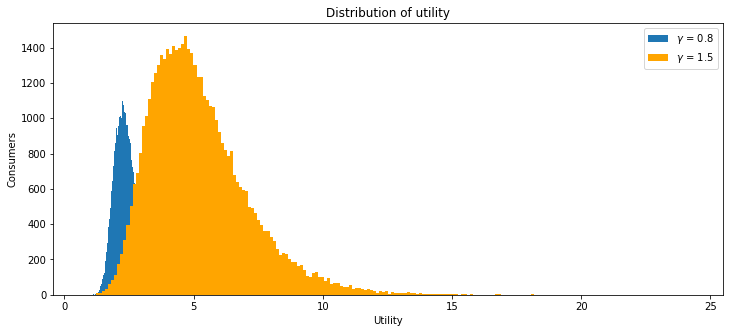

In [30]:
fig = plt.figure(figsize=(12,5))
plt.hist(u_vec, bins=200, label='$\gamma$ = 0.8')
plt.hist(u_vec_new, bins=200, color='orange', label='$\gamma$ = 1.5')
plt.legend()
plt.title('Distribution of utility')
plt.xlabel('Utility')
plt.ylabel('Consumers');